In [1]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns


Level of Grid alignment - Aligned - Misaligned - Intermediate

In [2]:
def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract specified 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels

    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")

            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")

            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue

            # Extract 'Volume Index' and 'Orientation'
            volume_indices = labels_df['Volume Index'].values
            orientations = labels_df['Orientation'].values

            # Validate volume indices
            max_index = data.shape[3] - 1
            if np.any(volume_indices > max_index) or np.any(volume_indices < 0):
                print(f"Error: Volume indices in {csv_path} are out of bounds for {nifti_path}")
                continue

            # Extract specified volumes using numpy.take for efficiency
            extracted_volumes = np.take(data, volume_indices, axis=3)  # Shape: (96, 96, 20, num_samples)
            print(f"Extracted volumes shape: {extracted_volumes.shape}")

            # Transpose to (num_samples, 96, 96, 20)
            extracted_volumes = np.transpose(extracted_volumes, (3, 0, 1, 2))  # Shape: (num_samples, 96, 96, 20)

            # Add channel dimension to make it (num_samples, 96, 96, 20, 1)
            extracted_volumes = extracted_volumes[..., np.newaxis]
            print(f"Reshaped volumes for CNN: {extracted_volumes.shape}")

            # Append to X and y
            X.append(extracted_volumes)
            y.append(orientations)

            print(f"Successfully extracted and reshaped {len(orientations)} samples from {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue

    # Concatenate all matched samples (X input with y "Orientation label")
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_samples, 96, 96, 20, 1)
        y = np.concatenate(y, axis=0)  # Shape: (total_samples,)
    else:
        X = np.array([]).reshape(0, 96, 96, 20, 1)
        y = np.array([])
        print("No data was loaded. Please check your input directories and file formats.")

    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")

    return X, y

def compute_angle_components(y):
    """
    Computes sine and cosine components for angles with 6-fold symmetry.
    """
    angles_rad = np.radians(6 * y)
    sin_component = np.sin(angles_rad)
    cos_component = np.cos(angles_rad)
    return np.vstack((sin_component, cos_component)).T  # Shape: (num_samples, 2)

def compute_alignment_score(y, normalize=True):
    """
    Computes the alignment score for each orientation angle based on 6-fold symmetry.

    Parameters:
    - y (array-like): Array of orientation angles in degrees.
    - normalize (bool): Whether to normalize the score to [0, 1].

    Returns:
    - alignment_score (numpy.ndarray): Array of alignment scores.
    """
    alignment_score = np.cos(np.radians(6 * y))
    if normalize:
        alignment_score = (alignment_score + 1) / 2  # Scale to [0, 1]
    return alignment_score

def build_regression_model(input_shape, output_units=2):
    """
    Builds and returns a 3D CNN regression model that outputs alignment score components.
    """
    model = Sequential()

    # First Convolutional Block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second Convolutional Block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third Convolutional Block
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))  # Adjusted pooling size

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_units, activation='linear'))  # Output layer for sine and cosine components

    return model

def compute_predicted_angles(y_pred_components):
    """
    Computes predicted angles from sine and cosine components.
    """
    sin_pred = y_pred_components[:, 0]
    cos_pred = y_pred_components[:, 1]
    angles_rad = np.arctan2(sin_pred, cos_pred)
    angles_deg = np.degrees(angles_rad) / 6  # Adjusting for 6-fold symmetry
    angles_deg = (angles_deg + 360) % 360  # Normalize angles between 0 and 360
    return angles_deg




def plot_orientation_distribution_with_hex_wave(y):
    """
    Plots the distribution of orientation labels with a 6-fold hexagonal oscillation overlay.
    """
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    ax1 = plt.gca()
    sns.histplot(y, bins=60, kde=False, color='skyblue', alpha=0.6, edgecolor='black')
    plt.title('Distribution of Orientation Labels with Hexagonal Oscillation')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Frequency')

    # Generate degrees for the overlay
    degrees = np.linspace(0, 360, 1000)
    hex_wave = 80 * (np.cos(np.radians(degrees * 6 - 30)) + 1) / 2  # Normalized and scaled

    # Plot the hexagonal oscillation
    plt.plot(degrees, hex_wave, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

def compile_regression_model(model, learning_rate=0.001):
    """
    Compiles the 3D CNN regression model.

    Parameters:
    - model (tensorflow.keras.Model): The 3D CNN model to compile.
    - learning_rate (float): Learning rate for the optimizer.

    Returns:
    - model (tensorflow.keras.Model): The compiled model.
    """
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=[MeanAbsoluteError()])
    return model

def evaluate_model(y_true, y_pred):
    """
    Evaluates the model using MAE, RMSE, and R² metrics.

    Parameters:
    - y_true (array-like): True alignment scores.
    - y_pred (array-like): Predicted alignment scores.

    Returns:
    - metrics_dict (dict): Dictionary containing MAE, RMSE, and R² scores.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict

def plot_predictions(y_true, y_pred):
    """
    Plots Predicted vs. Actual Alignment Scores.

    Parameters:
    - y_true (array-like): True alignment scores.
    - y_pred (array-like): Predicted alignment scores.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='k')
    plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Alignment Score')
    plt.ylabel('Predicted Alignment Score')
    plt.title('Predicted vs. Actual Alignment Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred):
    """
    Plots the distribution of residuals.

    Parameters:
    - y_true (array-like): True alignment scores.
    - y_pred (array-like): Predicted alignment scores.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True, color='skyblue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Matched: /Users/danielledowe/Deskto

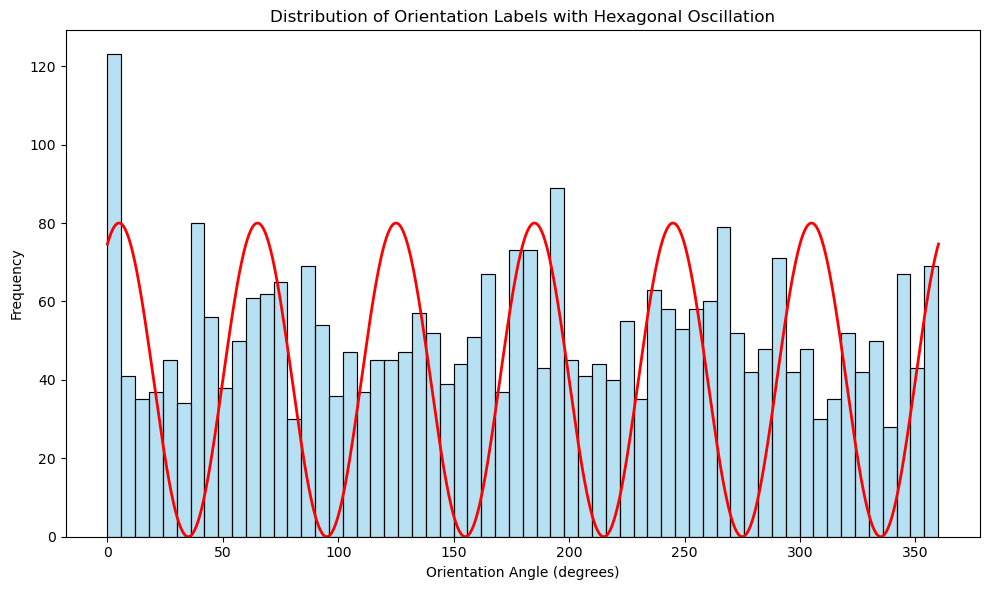


Splitting data into training and testing sets (80% training, 20% testing)...


In [3]:
def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract specified 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels

    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")

            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")

            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue

            # Extract 'Volume Index' and 'Orientation'
            volume_indices = labels_df['Volume Index'].values
            orientations = labels_df['Orientation'].values

            # Validate volume indices
            max_index = data.shape[3] - 1
            if np.any(volume_indices > max_index) or np.any(volume_indices < 0):
                print(f"Error: Volume indices in {csv_path} are out of bounds for {nifti_path}")
                continue

            # Extract specified volumes using numpy.take for efficiency
            extracted_volumes = np.take(data, volume_indices, axis=3)  # Shape: (96, 96, 20, num_samples)
            print(f"Extracted volumes shape: {extracted_volumes.shape}")

            # Transpose to (num_samples, 96, 96, 20)
            extracted_volumes = np.transpose(extracted_volumes, (3, 0, 1, 2))  # Shape: (num_samples, 96, 96, 20)

            # Add channel dimension to make it (num_samples, 96, 96, 20, 1)
            extracted_volumes = extracted_volumes[..., np.newaxis]
            print(f"Reshaped volumes for CNN: {extracted_volumes.shape}")

            # Append to X and y
            X.append(extracted_volumes)
            y.append(orientations)

            print(f"Successfully extracted and reshaped {len(orientations)} samples from {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue

    # Concatenate all matched samples (X input with y "Orientation label")
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_samples, 96, 96, 20, 1)
        y = np.concatenate(y, axis=0)  # Shape: (total_samples,)
    else:
        X = np.array([]).reshape(0, 96, 96, 20, 1)
        y = np.array([])
        print("No data was loaded. Please check your input directories and file formats.")

    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")

    return X, y

def compute_angle_components(y, normalize=True):
    """
    Computes sine and cosine components for angles with 6-fold symmetry.

    Parameters:
    - y (array-like): Array of orientation angles in degrees.
    - normalize (bool): Whether to normalize the score to [0, 1].

    Returns:
    - angle_components (numpy.ndarray): Array with sine and cosine components.
    """
    angles_rad = np.radians(6 * y)  # 6-fold symmetry
    sin_component = np.sin(angles_rad)
    cos_component = np.cos(angles_rad)
    angle_components = np.vstack((sin_component, cos_component)).T  # Shape: (num_samples, 2)
    return angle_components

def build_regression_model(input_shape, output_units=2):
    """
    Builds and returns a 3D CNN regression model that outputs sine and cosine components.

    Parameters:
    - input_shape (tuple): Shape of the input data (96, 96, 20, 1)
    - output_units (int): Number of output units (default is 2 for sine and cosine)

    Returns:
    - model (tensorflow.keras.Model): The constructed 3D CNN model
    """
    model = Sequential()

    # First Convolutional Block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second Convolutional Block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third Convolutional Block
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # Adjusted pooling size to prevent negative dimensions
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_units, activation='linear'))  # Output layer for sine and cosine components

    return model

def angular_loss(y_true, y_pred):
    """
    Custom loss function that computes the mean squared error between the true and predicted sine and cosine components.

    Parameters:
    - y_true (tensor): True sine and cosine components.
    - y_pred (tensor): Predicted sine and cosine components.

    Returns:
    - loss (tensor): Computed loss value.
    """
    return K.mean(K.square(y_true - y_pred), axis=-1)

def compile_regression_model(model, learning_rate=0.001):
    """
    Compiles the 3D CNN regression model with a custom loss function.

    Parameters:
    - model (tensorflow.keras.Model): The 3D CNN model to compile.
    - learning_rate (float): Learning rate for the optimizer.

    Returns:
    - model (tensorflow.keras.Model): The compiled model.
    """
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=angular_loss,
                  metrics=['mean_absolute_error'])
    return model

def plot_orientation_distribution_with_hex_wave(y):
    """
    Plots the distribution of orientation labels with a 6-fold hexagonal oscillation overlay.
    """
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    ax1 = plt.gca()
    sns.histplot(y, bins=60, kde=False, color='skyblue', alpha=0.6, edgecolor='black')
    plt.title('Distribution of Orientation Labels with Hexagonal Oscillation')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Frequency')

    # Generate degrees for the overlay
    degrees = np.linspace(0, 360, 1000)
    hex_wave = 80 * (np.cos(np.radians(degrees * 6 - 30)) + 1) / 2  # Normalized and scaled

    # Plot the hexagonal oscillation
    plt.plot(degrees, hex_wave, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred_angles):
    """
    Evaluates the model using MAE, RMSE, and R² metrics.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.

    Returns:
    - metrics_dict (dict): Dictionary containing MAE, RMSE, and R² scores.
    """
    mae = mean_absolute_error(y_true, y_pred_angles)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_angles))
    r2 = r2_score(y_true, y_pred_angles)
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict

def plot_predictions(y_true, y_pred_angles):
    """
    Plots Predicted vs. Actual Orientation Angles.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred_angles, alpha=0.5, edgecolors='k')
    plt.plot([0, 360], [0, 360], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Orientation Angle (degrees)')
    plt.ylabel('Predicted Orientation Angle (degrees)')
    plt.title('Predicted vs. Actual Orientation Angles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred_angles):
    """
    Plots the distribution of residuals.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    residuals = y_true - y_pred_angles
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True, color='skyblue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted) Degrees')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_bold_intensity_vs_alignment(X_test, y_test, y_pred_angles):
    """
    Analyzes and plots how BOLD intensity relates to grid alignment.

    Parameters:
    - X_test (numpy.ndarray): Test set fMRI data.
    - y_test (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    # Compute mean BOLD intensity for each sample across all voxels
    mean_bold = X_test.mean(axis=(1, 2, 3, 4))  # Shape: (num_samples,)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=mean_bold, y=y_test, label='Actual', alpha=0.6)
    sns.scatterplot(x=mean_bold, y=y_pred_angles, label='Predicted', alpha=0.6)
    plt.title('BOLD Intensity vs. Orientation Angle')
    plt.xlabel('Mean BOLD Intensity')
    plt.ylabel('Orientation Angle (degrees)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute and display correlation
    actual_corr = np.corrcoef(mean_bold, y_test)[0, 1]
    predicted_corr = np.corrcoef(mean_bold, y_pred_angles)[0, 1]
    print(f"Correlation between Mean BOLD Intensity and Actual Orientation: {actual_corr:.4f}")
    print(f"Correlation between Mean BOLD Intensity and Predicted Orientation: {predicted_corr:.4f}")

def plot_activation_maps(model, X_sample, title='Activation Maps'):
    """
    Plots activation maps from the first convolutional layer for a given sample.

    Parameters:
    - model (tensorflow.keras.Model): Trained 3D CNN model.
    - X_sample (numpy.ndarray): Single fMRI sample with shape (1, 96, 96, 20, 1).
    - title (str): Title for the plot.
    """

    # Create a model that outputs the activations of the first Conv3D layer
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv3D)]
    activation_model = Model(inputs=model.input, outputs=layer_outputs[0])

    activations = activation_model.predict(X_sample)
    num_filters = activations.shape[-1]

    # Plot the activations of the first 16 filters
    plt.figure(figsize=(20, 20))
    for i in range(min(16, num_filters)):
        ax = plt.subplot(4, 4, i + 1)
        # Take the mean across the depth axis for visualization
        activation = activations[0, :, :, :, i].mean(axis=2)
        sns.heatmap(activation, cmap='viridis', cbar=False)
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    Plots the training and validation loss and MAE over epochs.

    Parameters:
    - history (tensorflow.keras.callbacks.History): History object from model training.
    """
    plt.figure(figsize=(12, 5))

    # Plot Mean Absolute Error (MAE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE', marker='o')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    # Plot Loss (Custom Angular Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (Angular Loss)', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss (Angular Loss)', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Angular Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_performance_metrics(metrics):
    """
    Creates a bar plot for the performance metrics.

    Parameters:
    - metrics (dict): Dictionary containing performance metrics.
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    for index, value in enumerate(metrics.values()):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center')
    plt.tight_layout()
    plt.show()

def plot_bland_altman(y_true, y_pred_angles):
    """
    Generates a Bland-Altman plot to assess agreement between true and predicted angles.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    average = (y_true + y_pred_angles) / 2
    difference = y_true - y_pred_angles

    plt.figure(figsize=(10, 5))
    plt.scatter(average, difference, alpha=0.5, edgecolors='k')
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
    plt.xlabel('Average of Actual and Predicted Orientation Angles (degrees)')
    plt.ylabel('Difference (Actual - Predicted) Degrees')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Bland-Altman plot generated.")

def main():
    # Define the input and output directories
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'

    # Define the required columns in the CSV files
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}

    # Get the list of run prefixes
    prefixes = get_run_prefixes()

    # Load the data
    X, y = load_data(input_dir, output_dir, prefixes, required_columns)
    print(f"Total samples: {X.shape[0]}, Volume shape: {X.shape[1:]}, Labels shape: {y.shape}")

    if X.shape[0] == 0:
        print("No data available for training. Exiting.")
        return

    # Compute angle components instead of alignment scores
    print("\nComputing angle components...")
    angle_components = compute_angle_components(y, normalize=False)  # No normalization needed
    print(f"Angle components computed. Shape: {angle_components.shape}")

    # Plot LABEL DISTRIBUTION with Hexagonal Oscillation Overlay
    plot_orientation_distribution_with_hex_wave(y)

    # Split the data into training and testing sets
    print("\nSplitting data into training and testing sets (80% training, 20% testing)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, angle_components, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"Number of samples in training set: {X_train.shape[0]}")
    print(f"Number of samples in testing set: {X_test.shape[0]}")

    # Normalize fMRI data using z-scoring based on training data
    print("\nNormalizing fMRI data using z-scoring...")
    mean = X_train.mean()
    std = X_train.std()
    print(f"Training data mean: {mean:.4f}, std: {std:.4f}")

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    print("Data normalization complete.")

    # Define and compile the 3D CNN regression model
    print("\nDefining and compiling the 3D CNN regression model...")
    input_shape = X_train.shape[1:]  # (96, 96, 20, 1)
    model = build_regression_model(input_shape, output_units=2)
    model = compile_regression_model(model, learning_rate=0.001)
    model.summary()
    print("Model compiled successfully.")

    # Train the model
    print("\nTraining the 3D CNN regression model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=6,
        verbose=1
    )
    print("Model training complete.")

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    # Evaluate the model on the test set
    print("\nEvaluating the model on the test set...")
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss (Angular Loss): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Generate predictions as sine and cosine components
    print("\nGenerating predictions...")
    y_pred_components = model.predict(X_test, batch_size=5)
    print(f"Predictions generated. Shape: {y_pred_components.shape}")

    # Convert predicted components back to angles
    def compute_predicted_angles(y_pred_components):
        """
        Computes predicted angles from sine and cosine components.

        Parameters:
        - y_pred_components (numpy.ndarray): Predicted sine and cosine components.

        Returns:
        - angles_deg (numpy.ndarray): Predicted orientation angles in degrees.
        """
        sin_pred = y_pred_components[:, 0]
        cos_pred = y_pred_components[:, 1]
        angles_rad = np.arctan2(sin_pred, cos_pred)
        angles_deg = np.degrees(angles_rad) / 6  # Adjusting for 6-fold symmetry
        angles_deg = (angles_deg + 360) % 360  # Normalize angles between 0 and 360
        return angles_deg

    predicted_angles = compute_predicted_angles(y_pred_components)
    true_angles = compute_predicted_angles(y_test)
    print(f"Predicted angles computed. Shape: {predicted_angles.shape}")
    print(f"True angles computed. Shape: {true_angles.shape}")

    # Plot Predicted vs. Actual Orientation Angles
    plot_predictions(true_angles, predicted_angles)

    # Plot Residuals Distribution
    plot_residuals(true_angles, predicted_angles)

    # Calculate and Display Metrics
    metrics = evaluate_model(true_angles, predicted_angles)
    print(f"\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Bar Plot for Error Metrics
    plot_performance_metrics(metrics)

    # Bland-Altman Plot
    plot_bland_altman(true_angles, predicted_angles)

    # Analyze BOLD Intensity vs. Alignment
    plot_bold_intensity_vs_alignment(X_test, true_angles, predicted_angles)

    # Plot Activation Maps for a Sample
    sample_index = 0  # Change this index to visualize different samples
    X_sample = X_test[sample_index:sample_index+1]  # Shape: (1, 96, 96, 20, 1)
    plot_activation_maps(model, X_sample, title='Activation Maps for Sample 1')

    print("\nEvaluation complete.")

if __name__ == "__main__":
    main()


Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run001.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run001_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run002.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run002_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run003.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run003_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run004.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run004_orientations.csv
Matched: /Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT/s05_run005.nii <--> /Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation/s05_run005_orientations.csv
Matched: /Users/danielledowe/Deskto

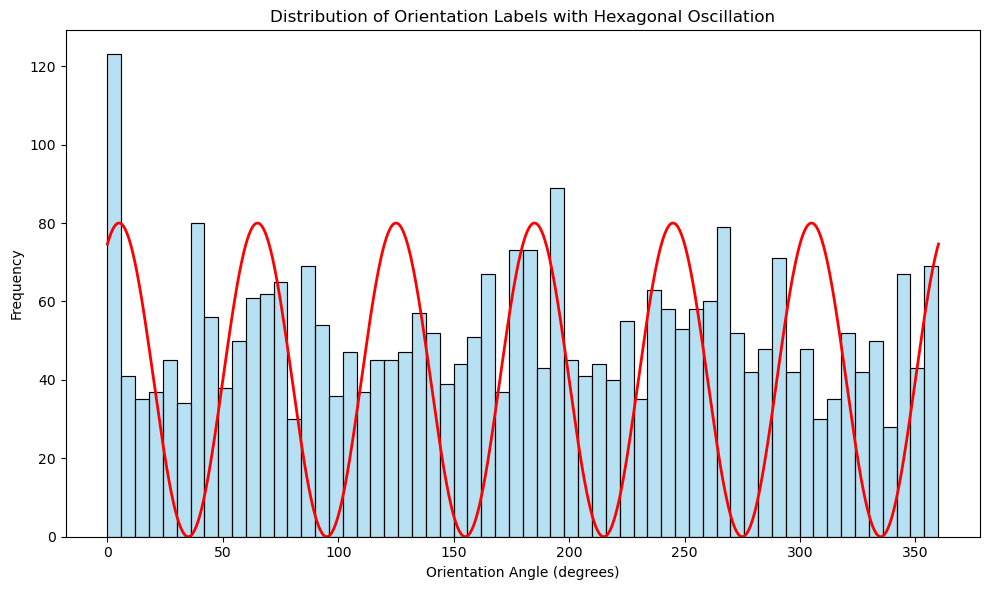


Splitting data into training and testing sets (80% training, 20% testing)...
Number of samples in training set: 2489
Number of samples in testing set: 623

Normalizing fMRI data using z-scoring...
Training data mean: 2.0544, std: 75.6684
Data normalization complete.

Defining and compiling the 3D CNN regression model...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 96, 96, 20, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 48, 48, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 48, 48, 10, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 10, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 24, 24, 5, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 24, 5, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 5, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 12, 12, 5, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 92160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    23,593,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,872,194 (91.07 MB)

 Trainable params: 23,871,746 (91.06 MB)

 Non-trainable params: 448 (1.75 KB)

Model compiled successfully.

Training the 3D CNN regression model...
Epoch 1/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1206s 3s/step - loss: 109.6196 - mean_absolute_error: 3.2880 - val_loss: 166.4875 - val_mean_absolute_error: 10.9949
Epoch 2/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1175s 3s/step - loss: 0.4999 - mean_absolute_error: 0.6290 - val_loss: 0.4995 - val_mean_absolute_error: 0.6294
Epoch 3/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1669s 4s/step - loss: 0.4997 - mean_absolute_error: 0.6285 - val_loss: 0.4990 - val_mean_absolute_error: 0.6292
Epoch 4/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1331s 3s/step - loss: 0.4994 - mean_absolute_error: 0.6279 - val_loss: 0.4986 - val_mean_absolute_error: 0.6289
Epoch 5/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1428s 3s/step - loss: 0.4992 - mean_absolute_error: 0.6302 - val_loss: 0.4984 - val_mean_absolute_error: 0.6288
Epoch 6/20
415/415 ━━━━━━━━━━━━━━━━━━━━ 1108s 3s/step - loss: 0.4991 - mean_absolute_error: 0.6263 - val_loss: 0.4982 - val_mean_absolute_error: 0.6286
Epoch 7/20
41

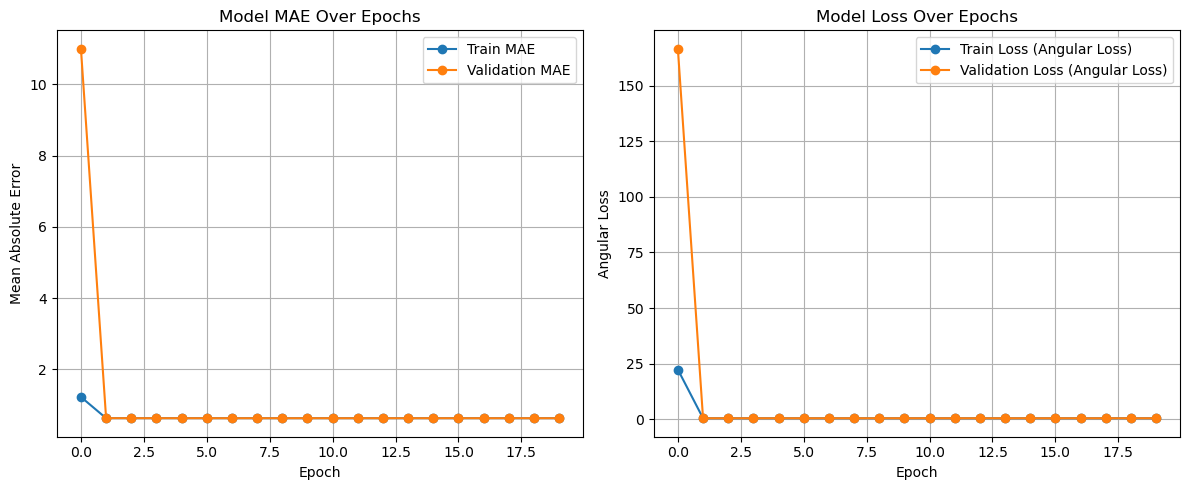


Evaluating the model on the test set...
Test Loss (Angular Loss): 0.4980
Test MAE: 0.6284

Generating predictions...
125/125 ━━━━━━━━━━━━━━━━━━━━ 37s 292ms/step
Predictions generated. Shape: (623, 2)
Predicted angles computed. Shape: (623,)
True angles computed. Shape: (623,)


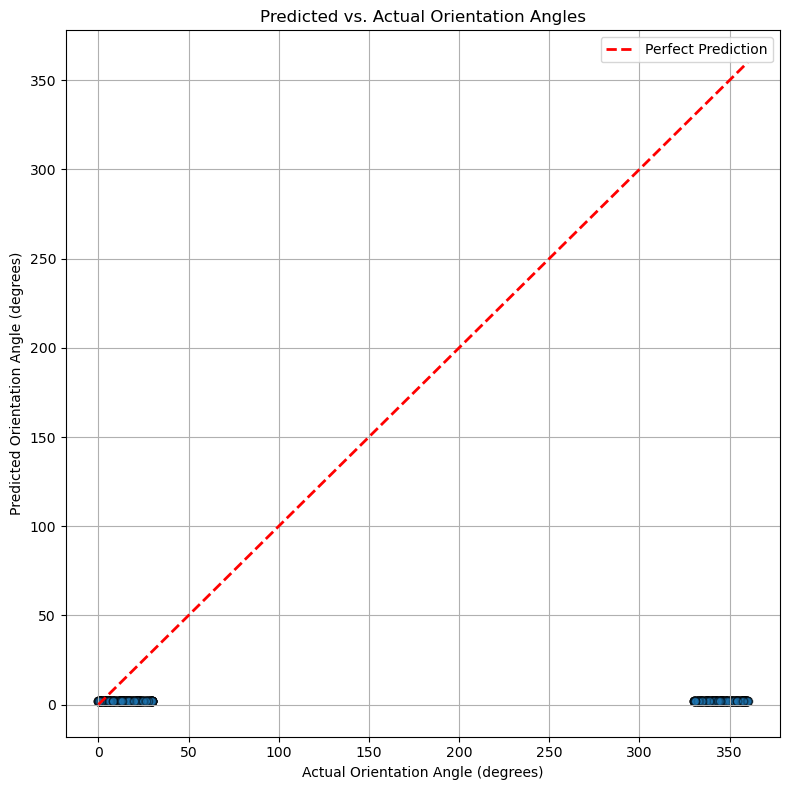

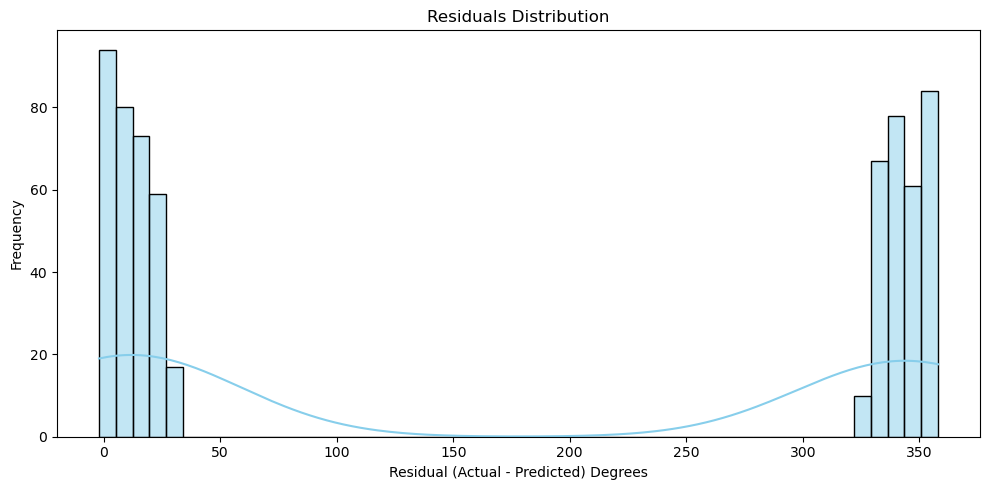


Model Performance Metrics:
MAE: 171.8180
RMSE: 238.8099
R2: -1.0698


/var/folders/tt/1l08355d2tb87jgn9r18nm4r0000gn/T/ipykernel_16138/2331926130.py:366: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


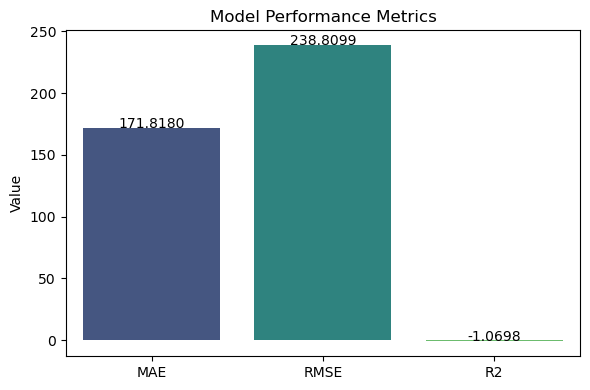

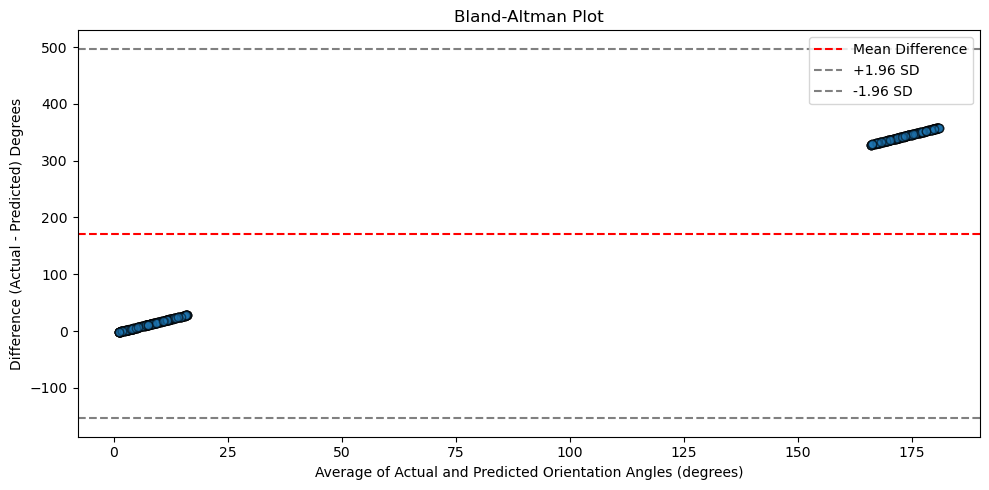

Bland-Altman plot generated.


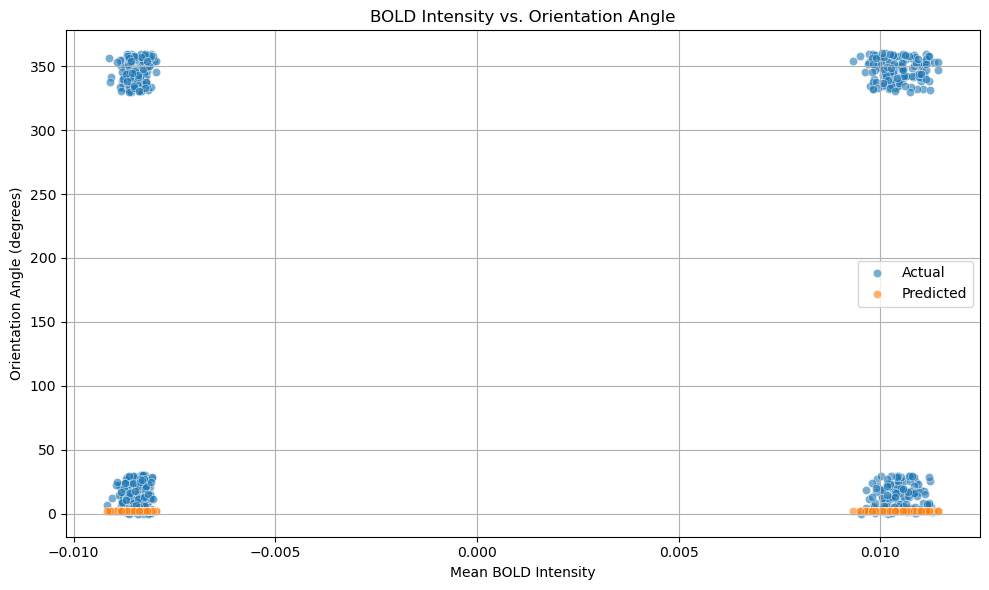

/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation between Mean BOLD Intensity and Actual Orientation: 0.0204
Correlation between Mean BOLD Intensity and Predicted Orientation: nan


AttributeError: The layer sequential has never been called and thus has no defined input.

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def get_run_prefixes():
    """Generate run prefixes for s05 and s14 runs."""
    s05 = [f"s05_run{str(i).zfill(3)}" for i in range(1, 13)]  # s05_run001 to s05_run012
    s14 = [f"s14_run{str(i).zfill(3)}" for i in range(2, 13)]  # s14_run002 to s14_run012
    return s05 + s14

def match_files(input_dir, output_dir, prefixes):
    """Match NIfTI files with their corresponding CSV label files."""
    matched = []
    for prefix in prefixes:
        nifti_path = os.path.join(input_dir, f"{prefix}.nii")
        csv_path = os.path.join(output_dir, f"{prefix}_orientations.csv")
        if os.path.isfile(nifti_path) and os.path.isfile(csv_path):
            matched.append((nifti_path, csv_path))
            print(f"Matched: {nifti_path} <--> {csv_path}")
        else:
            print(f"Warning: Missing file for prefix '{prefix}'")
    return matched

def load_data(input_dir, output_dir, prefixes, required_columns):
    """Load data and extract specified 3D volumes with corresponding labels."""
    X = []  # List to store 3D volumes
    y = []  # List to store orientation labels

    for nifti_path, csv_path in match_files(input_dir, output_dir, prefixes):
        try:
            # Load NIfTI data
            nii_img = nib.load(nifti_path)
            data = nii_img.get_fdata()
            print(f"Loaded NIfTI: {nifti_path} with shape {data.shape}")

            # Load CSV labels
            labels_df = pd.read_csv(csv_path)
            print(f"Loaded CSV: {csv_path} with {len(labels_df)} entries")

            # Validate CSV columns
            if not required_columns.issubset(labels_df.columns):
                print(f"Error: Missing columns in {csv_path}. Required columns: {required_columns}")
                continue

            # Extract 'Volume Index' and 'Orientation'
            volume_indices = labels_df['Volume Index'].values
            orientations = labels_df['Orientation'].values

            # Validate volume indices
            max_index = data.shape[3] - 1
            if np.any(volume_indices > max_index) or np.any(volume_indices < 0):
                print(f"Error: Volume indices in {csv_path} are out of bounds for {nifti_path}")
                continue

            # Extract specified volumes using numpy.take for efficiency
            extracted_volumes = np.take(data, volume_indices, axis=3)  # Shape: (96, 96, 20, num_samples)
            print(f"Extracted volumes shape: {extracted_volumes.shape}")

            # Transpose to (num_samples, 96, 96, 20)
            extracted_volumes = np.transpose(extracted_volumes, (3, 0, 1, 2))  # Shape: (num_samples, 96, 96, 20)

            # Add channel dimension to make it (num_samples, 96, 96, 20, 1)
            extracted_volumes = extracted_volumes[..., np.newaxis]
            print(f"Reshaped volumes for CNN: {extracted_volumes.shape}")

            # Append to X and y
            X.append(extracted_volumes)
            y.append(orientations)

            print(f"Successfully extracted and reshaped {len(orientations)} samples from {nifti_path} and {csv_path}\n")
        except Exception as e:
            print(f"Error processing {nifti_path} and {csv_path}: {e}")
            continue

    # Concatenate all matched samples (X input with y "Orientation label")
    if X:
        X = np.concatenate(X, axis=0)  # Shape: (total_samples, 96, 96, 20, 1)
        y = np.concatenate(y, axis=0)  # Shape: (total_samples,)
    else:
        X = np.array([]).reshape(0, 96, 96, 20, 1)
        y = np.array([])
        print("No data was loaded. Please check your input directories and file formats.")

    print(f"Final X shape: {X.shape}")
    print(f"Final y shape: {y.shape}")

    return X, y

def compute_angle_components(y, normalize=True):
    """
    Computes sine and cosine components for angles with 6-fold symmetry.

    Parameters:
    - y (array-like): Array of orientation angles in degrees.
    - normalize (bool): Whether to normalize the score to [0, 1].

    Returns:
    - angle_components (numpy.ndarray): Array with sine and cosine components.
    """
    angles_rad = np.radians(6 * y)  # 6-fold symmetry
    sin_component = np.sin(angles_rad)
    cos_component = np.cos(angles_rad)
    angle_components = np.vstack((sin_component, cos_component)).T  # Shape: (num_samples, 2)
    return angle_components

def build_regression_model(input_shape, output_units=2):
    """
    Builds and returns a 3D CNN regression model that outputs sine and cosine components.

    Parameters:
    - input_shape (tuple): Shape of the input data (96, 96, 20, 1)
    - output_units (int): Number of output units (default is 2 for sine and cosine)

    Returns:
    - model (tensorflow.keras.Model): The constructed 3D CNN model
    """
    model = Sequential()

    # First Convolutional Block
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Second Convolutional Block
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    # Third Convolutional Block
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    # Adjusted pooling size to prevent negative dimensions
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_units, activation='linear'))  # Output layer for sine and cosine components

    return model

def angular_loss(y_true, y_pred):
    """
    Custom loss function that computes the mean squared error between the true and predicted sine and cosine components.

    Parameters:
    - y_true (tensor): True sine and cosine components.
    - y_pred (tensor): Predicted sine and cosine components.

    Returns:
    - loss (tensor): Computed loss value.
    """
    return K.mean(K.square(y_true - y_pred), axis=-1)

def compile_regression_model(model, learning_rate=0.001):
    """
    Compiles the 3D CNN regression model with a custom loss function.

    Parameters:
    - model (tensorflow.keras.Model): The 3D CNN model to compile.
    - learning_rate (float): Learning rate for the optimizer.

    Returns:
    - model (tensorflow.keras.Model): The compiled model.
    """
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss=angular_loss,
                  metrics=['mean_absolute_error'])
    return model

def plot_orientation_distribution_with_hex_wave(y):
    """
    Plots the distribution of orientation labels with a 6-fold hexagonal oscillation overlay.
    """
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    ax1 = plt.gca()
    sns.histplot(y, bins=60, kde=False, color='skyblue', alpha=0.6, edgecolor='black')
    plt.title('Distribution of Orientation Labels with Hexagonal Oscillation')
    plt.xlabel('Orientation Angle (degrees)')
    plt.ylabel('Frequency')

    # Generate degrees for the overlay
    degrees = np.linspace(0, 360, 1000)
    hex_wave = 80 * (np.cos(np.radians(degrees * 6 - 30)) + 1) / 2  # Normalized and scaled

    # Plot the hexagonal oscillation
    plt.plot(degrees, hex_wave, color='red', linewidth=2)
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred_angles):
    """
    Evaluates the model using MAE, RMSE, and R² metrics.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.

    Returns:
    - metrics_dict (dict): Dictionary containing MAE, RMSE, and R² scores.
    """
    mae = mean_absolute_error(y_true, y_pred_angles)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_angles))
    r2 = r2_score(y_true, y_pred_angles)
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict

def plot_predictions(y_true, y_pred_angles):
    """
    Plots Predicted vs. Actual Orientation Angles.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred_angles, alpha=0.5, edgecolors='k')
    plt.plot([0, 360], [0, 360], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Orientation Angle (degrees)')
    plt.ylabel('Predicted Orientation Angle (degrees)')
    plt.title('Predicted vs. Actual Orientation Angles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred_angles):
    """
    Plots the distribution of residuals.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    residuals = y_true - y_pred_angles
    plt.figure(figsize=(10, 5))
    sns.histplot(residuals, bins=50, kde=True, color='skyblue')
    plt.title('Residuals Distribution')
    plt.xlabel('Residual (Actual - Predicted) Degrees')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def plot_bold_intensity_vs_alignment(X_test, y_true, y_pred_angles):
    """
    Analyzes and plots how BOLD intensity relates to grid alignment.

    Parameters:
    - X_test (numpy.ndarray): Test set fMRI data.
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    # Compute mean BOLD intensity for each sample across all voxels
    mean_bold = X_test.mean(axis=(1, 2, 3, 4))  # Shape: (num_samples,)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=mean_bold, y=y_true, label='Actual', alpha=0.6)
    sns.scatterplot(x=mean_bold, y=y_pred_angles, label='Predicted', alpha=0.6)
    plt.title('BOLD Intensity vs. Orientation Angle')
    plt.xlabel('Mean BOLD Intensity')
    plt.ylabel('Orientation Angle (degrees)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute and display correlation
    actual_corr = np.corrcoef(mean_bold, y_true)[0, 1]
    predicted_corr = np.corrcoef(mean_bold, y_pred_angles)[0, 1]
    print(f"Correlation between Mean BOLD Intensity and Actual Orientation: {actual_corr:.4f}")
    print(f"Correlation between Mean BOLD Intensity and Predicted Orientation: {predicted_corr:.4f}")

def plot_activation_maps(model, X_sample, title='Activation Maps'):
    """
    Plots activation maps from the first convolutional layer for a given sample.

    Parameters:
    - model (tensorflow.keras.Model): Trained 3D CNN model.
    - X_sample (numpy.ndarray): Single fMRI sample with shape (1, 96, 96, 20, 1).
    - title (str): Title for the plot.
    """

    # Create a model that outputs the activations of the first Conv3D layer
    layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv3D)]
    if not layer_outputs:
        print("No Conv3D layers found in the model.")
        return
    activation_model = Model(inputs=model.input, outputs=layer_outputs[0])

    activations = activation_model.predict(X_sample)
    num_filters = activations.shape[-1]

    # Plot the activations of the first 16 filters
    plt.figure(figsize=(20, 20))
    for i in range(min(16, num_filters)):
        ax = plt.subplot(4, 4, i + 1)
        # Take the mean across the depth axis for visualization
        activation = activations[0, :, :, :, i].mean(axis=2)
        sns.heatmap(activation, cmap='viridis', cbar=False)
        ax.set_title(f'Filter {i+1}')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    """
    Plots the training and validation loss and MAE over epochs.

    Parameters:
    - history (tensorflow.keras.callbacks.History): History object from model training.
    """
    plt.figure(figsize=(12, 5))

    # Plot Mean Absolute Error (MAE)
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE', marker='o')
    plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE', marker='o')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

    # Plot Loss (Custom Angular Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (Angular Loss)', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss (Angular Loss)', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Angular Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_performance_metrics(metrics):
    """
    Creates a bar plot for the performance metrics.

    Parameters:
    - metrics (dict): Dictionary containing performance metrics.
    """
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    for index, value in enumerate(metrics.values()):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center')
    plt.tight_layout()
    plt.show()

def plot_bland_altman(y_true, y_pred_angles):
    """
    Generates a Bland-Altman plot to assess agreement between true and predicted angles.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    """
    average = (y_true + y_pred_angles) / 2
    difference = y_true - y_pred_angles

    plt.figure(figsize=(10, 5))
    plt.scatter(average, difference, alpha=0.5, edgecolors='k')
    mean_diff = np.mean(difference)
    std_diff = np.std(difference)
    plt.axhline(mean_diff, color='red', linestyle='--', label='Mean Difference')
    plt.axhline(mean_diff + 1.96 * std_diff, color='gray', linestyle='--', label='+1.96 SD')
    plt.axhline(mean_diff - 1.96 * std_diff, color='gray', linestyle='--', label='-1.96 SD')
    plt.xlabel('Average of Actual and Predicted Orientation Angles (degrees)')
    plt.ylabel('Difference (Actual - Predicted) Degrees')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print("Bland-Altman plot generated.")

def compute_alignment_levels(y, num_levels=6):
    """
    Assigns each angle to a discrete alignment level based on 6-fold symmetry.

    Parameters:
    - y (array-like): Array of orientation angles in degrees.
    - num_levels (int): Number of alignment levels (default is 6).

    Returns:
    - alignment_levels (numpy.ndarray): Array of alignment levels (0 to num_levels-1).
    """
    # Each level corresponds to a 60-degree segment
    bin_size = 360 / num_levels
    alignment_levels = np.floor(y / bin_size).astype(int) % num_levels
    return alignment_levels

def plot_alignment_level_performance(y_true, y_pred_angles, num_levels=6):
    """
    Plots model performance metrics per alignment level.

    Parameters:
    - y_true (array-like): True orientation angles in degrees.
    - y_pred_angles (array-like): Predicted orientation angles in degrees.
    - num_levels (int): Number of alignment levels (default is 6).
    """
    alignment_levels = compute_alignment_levels(y_true, num_levels=num_levels)
    metrics_per_level = {'MAE': [], 'RMSE': [], 'R2': []}
    level_labels = []

    for level in range(num_levels):
        idx = alignment_levels == level
        if np.sum(idx) == 0:
            metrics_per_level['MAE'].append(np.nan)
            metrics_per_level['RMSE'].append(np.nan)
            metrics_per_level['R2'].append(np.nan)
            level_labels.append(f'Level {level}')
            continue
        true_angles = y_true[idx]
        pred_angles = y_pred_angles[idx]
        metrics = evaluate_model(true_angles, pred_angles)
        metrics_per_level['MAE'].append(metrics['MAE'])
        metrics_per_level['RMSE'].append(metrics['RMSE'])
        metrics_per_level['R2'].append(metrics['R2'])
        level_labels.append(f'Level {level}')

    # Plotting MAE per alignment level
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    sns.barplot(x=level_labels, y=metrics_per_level['MAE'], palette='Blues_d')
    plt.title('MAE per Alignment Level')
    plt.xlabel('Alignment Level')
    plt.ylabel('Mean Absolute Error (Degrees)')
    plt.ylim(0, np.nanmax(metrics_per_level['MAE']) + 5)
    for i, v in enumerate(metrics_per_level['MAE']):
        if not np.isnan(v):
            plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

    # Plotting RMSE per alignment level
    plt.subplot(1, 3, 2)
    sns.barplot(x=level_labels, y=metrics_per_level['RMSE'], palette='Greens_d')
    plt.title('RMSE per Alignment Level')
    plt.xlabel('Alignment Level')
    plt.ylabel('Root Mean Squared Error (Degrees)')
    plt.ylim(0, np.nanmax(metrics_per_level['RMSE']) + 5)
    for i, v in enumerate(metrics_per_level['RMSE']):
        if not np.isnan(v):
            plt.text(i, v + 0.1, f"{v:.2f}", ha='center')

    # Plotting R2 per alignment level
    plt.subplot(1, 3, 3)
    sns.barplot(x=level_labels, y=metrics_per_level['R2'], palette='Oranges_d')
    plt.title('R² per Alignment Level')
    plt.xlabel('Alignment Level')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    for i, v in enumerate(metrics_per_level['R2']):
        if not np.isnan(v):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

    plt.tight_layout()
    plt.show()

def main():
    # Define the input and output directories
    input_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/INPUT'
    output_dir = '/Users/danielledowe/Desktop/BME PREPROCESS MERGE/OUTPUT Preprocessed Orientation'

    # Define the required columns in the CSV files
    required_columns = {'Volume Index', 'Volume Start Time (s)', 'Label Time (s)', 'Orientation'}

    # Get the list of run prefixes
    prefixes = get_run_prefixes()

    # Load the data
    X, y = load_data(input_dir, output_dir, prefixes, required_columns)
    print(f"Total samples: {X.shape[0]}, Volume shape: {X.shape[1:]}, Labels shape: {y.shape}")

    if X.shape[0] == 0:
        print("No data available for training. Exiting.")
        return

    # Compute angle components instead of alignment scores
    print("\nComputing angle components...")
    angle_components = compute_angle_components(y, normalize=False)  # No normalization needed
    print(f"Angle components computed. Shape: {angle_components.shape}")

    # Plot LABEL DISTRIBUTION with Hexagonal Oscillation Overlay
    plot_orientation_distribution_with_hex_wave(y)

    # Split the data into training and testing sets
    print("\nSplitting data into training and testing sets (80% training, 20% testing)...")
    X_train, X_test, y_train, y_test = train_test_split(
        X, angle_components, test_size=0.2, random_state=42, shuffle=True
    )
    print(f"Number of samples in training set: {X_train.shape[0]}")
    print(f"Number of samples in testing set: {X_test.shape[0]}")

    # Normalize fMRI data using z-scoring based on training data
    print("\nNormalizing fMRI data using z-scoring...")
    mean = X_train.mean()
    std = X_train.std()
    print(f"Training data mean: {mean:.4f}, std: {std:.4f}")

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    print("Data normalization complete.")

    # Define and compile the 3D CNN regression model
    print("\nDefining and compiling the 3D CNN regression model...")
    input_shape = X_train.shape[1:]  # (96, 96, 20, 1)
    model = build_regression_model(input_shape, output_units=2)
    model = compile_regression_model(model, learning_rate=0.001)
    model.summary()
    print("Model compiled successfully.")

    # Train the model
    print("\nTraining the 3D CNN regression model...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,  # Increased epochs for better training
        batch_size=6,  # Adjust based on your system's memory
        verbose=1
    )
    print("Model training complete.")

    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    # Evaluate the model on the test set
    print("\nEvaluating the model on the test set...")
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss (Angular Loss): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")

    # Generate predictions as sine and cosine components
    print("\nGenerating predictions...")
    y_pred_components = model.predict(X_test, batch_size=5)
    print(f"Predictions generated. Shape: {y_pred_components.shape}")

    # Convert predicted components back to angles
    def compute_predicted_angles(y_pred_components):
        """
        Computes predicted angles from sine and cosine components.

        Parameters:
        - y_pred_components (numpy.ndarray): Predicted sine and cosine components.

        Returns:
        - angles_deg (numpy.ndarray): Predicted orientation angles in degrees.
        """
        sin_pred = y_pred_components[:, 0]
        cos_pred = y_pred_components[:, 1]
        angles_rad = np.arctan2(sin_pred, cos_pred)
        angles_deg = np.degrees(angles_rad) / 6  # Adjusting for 6-fold symmetry
        angles_deg = (angles_deg + 360) % 360  # Normalize angles between 0 and 360
        return angles_deg

    predicted_angles = compute_predicted_angles(y_pred_components)
    true_angles = compute_predicted_angles(y_test)
    print(f"Predicted angles computed. Shape: {predicted_angles.shape}")
    print(f"True angles computed. Shape: {true_angles.shape}")

    # Plot Predicted vs. Actual Orientation Angles
    plot_predictions(true_angles, predicted_angles)

    # Plot Residuals Distribution
    plot_residuals(true_angles, predicted_angles)

    # Calculate and Display Metrics
    metrics = evaluate_model(true_angles, predicted_angles)
    print(f"\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Bar Plot for Error Metrics
    plot_performance_metrics(metrics)

    # Bland-Altman Plot
    plot_bland_altman(true_angles, predicted_angles)

    # Analyze BOLD Intensity vs. Alignment
    plot_bold_intensity_vs_alignment(X_test, true_angles, predicted_angles)

    # Plot Activation Maps for a Sample
    sample_index = 0  # Change this index to visualize different samples
    X_sample = X_test[sample_index:sample_index+1]  # Shape: (1, 96, 96, 20, 1)
    plot_activation_maps(model, X_sample, title='Activation Maps for Sample 1')

    # Analyze Performance per Alignment Level
    print("\nAnalyzing performance per alignment level...")
    plot_alignment_level_performance(true_angles, predicted_angles, num_levels=6)

    print("\nEvaluation complete.")

if __name__ == "__main__":
    main()


...